# Compute geostrophic geopotential from u,v 

Usually one computes ug and vg from Phi. 
Here we compute Phi_g from u and v. 

Phi_g is the potential of vector field fu,fv. Use windspharm library. 

In [120]:
import xarray as xr 
import windspharm
import numpy as np
import matplotlib.pyplot as plt

# Do it in 3D 

In [124]:
e53d = xr.open_dataset('/Users/bmapes/Box/era5_3D_3hours_20140916.nc')
e53d

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 32, time: 3)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 10 20 30 50 70 100 125 ... 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2014-09-16T10:00:00 ... 2014-09-16T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 01:50:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [125]:
u = e53d['u']
v = e53d['v']
Z = e53d['z']

## Compute global mean Z profile to add to hor. pattern of Zg

In [140]:
weights = np.cos(np.deg2rad(Z.latitude))
weights.name = "weights"
weights
globalZ = Z.weighted(weights).mean(("longitude", "latitude"))
globalZ

<xarray.DataArray 'z' (time: 3, level: 32)>
array([[302353.4    , 257764.44   , 232409.9    , 201080.08   ,
        180826.69   , 159765.81   , 146617.7    , 135696.89   ,
        126283.89   , 117984.15   , 110544.484  , 103782.164  ,
         91781.1    ,  81285.2    ,  71911.43   ,  63426.164  ,
         55666.523  ,  48513.703  ,  41876.406  ,  35680.32   ,
         29865.428  ,  24386.027  ,  21760.658  ,  19206.31   ,
         16719.451  ,  14297.057  ,  11935.997  ,   9632.792  ,
          7384.1025 ,   5186.5615 ,   3037.3843 ,    934.11725],
       [302349.28   , 257759.98   , 232405.27   , 201076.25   ,
        180823.38   , 159762.98   , 146614.7    , 135693.81   ,
        126280.94   , 117981.68   , 110542.234  , 103780.2    ,
         91779.77   ,  81284.47   ,  71911.336  ,  63426.348  ,
         55666.86   ,  48514.125  ,  41876.902  ,  35680.957  ,
         29866.123  ,  24386.674  ,  21761.252  ,  19206.842  ,
         16719.904  ,  14297.455  ,  11936.353  ,   9633.067  ,
          7384.2964 ,   5186.6167 ,   3037.2666 ,    933.7931 ],
       [302345.66   , 257756.58   , 232402.1    , 201073.42   ,
        180820.97   , 159760.78   , 146612.48   , 135691.64   ,
        126279.12   , 117980.02   , 110540.86   , 103779.19   ,
         91779.47   ,  81284.625  ,  71911.97   ,  63427.117  ,
         55667.69   ,  48514.984  ,  41877.805  ,  35681.875  ,
         29867.14   ,  24387.625  ,  21762.14   ,  19207.652  ,
         16720.623  ,  14298.093  ,  11936.956  ,   9633.627  ,
          7384.769  ,   5186.968  ,   3037.5166 ,    933.9053 ]],
      dtype=float32)
Coordinates:
  * level    (level) int32 10 20 30 50 70 100 125 ... 875 900 925 950 975 1000
  * time     (time) datetime64[ns] 2014-09-16T10:00:00 ... 2014-09-16T12:00:00

## Ready for geogeo (geostrophic geopotential)

In [205]:
#f = 2 Omega sin lat
Omega = 2*np.pi / 86164. #86400. # inverse second units, stellar day

# TEST! weaken Omega by 5% 

fu = u* 2*Omega * np.sin(u.latitude *np.pi/180.) 
fv = v* 2*Omega * np.sin(v.latitude *np.pi/180.) 

fV = windspharm.xarray.VectorWind(fu,fv)   # seems to work for all levels at once

Zg = fV.streamfunction() + globalZ
Za = (Z - Zg)

In [212]:
Z[1][9].level.values #200 hPa

array(200, dtype=int32)

Text(0.5, 1.0, 'gZa')

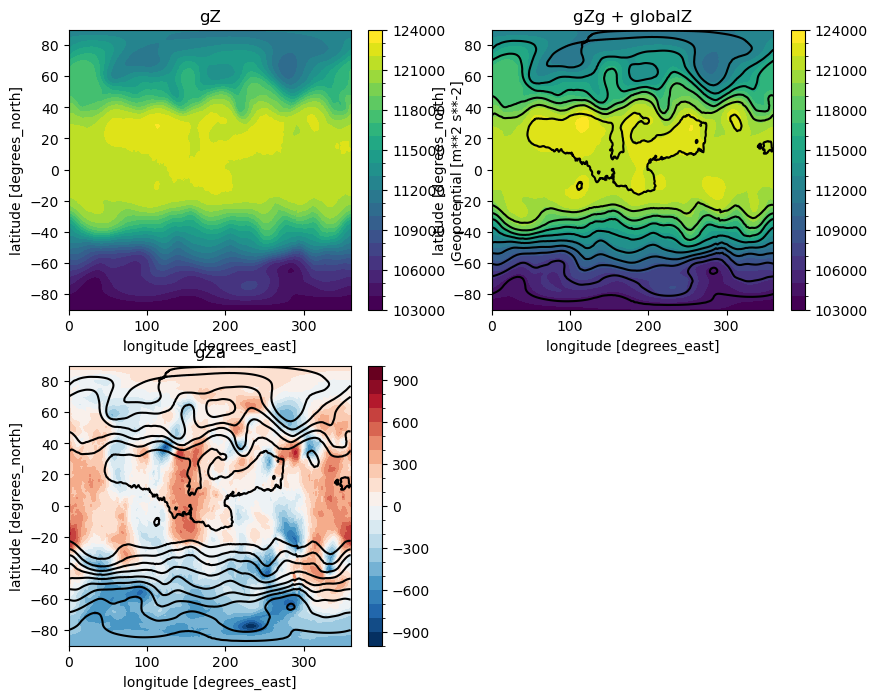

In [256]:
plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
Z[1][9].plot.contourf(levels=25)
plt.title('gZ')

plt.subplot(2, 2, 2)
Zg[1][9].plot.contourf(levels=25)
Z[1][9].plot.contour(levels=13, colors='k')
plt.title('gZg + globalZ')

plt.subplot(2, 2, 3)
Za[1][9].plot.contourf(levels=25)
Z[1][9].plot.contour(levels=13, colors='k')
plt.title('gZa')


Text(0.5, 1.0, 'ageostrophic (shaded) and geostrophic (contours) gZ200')

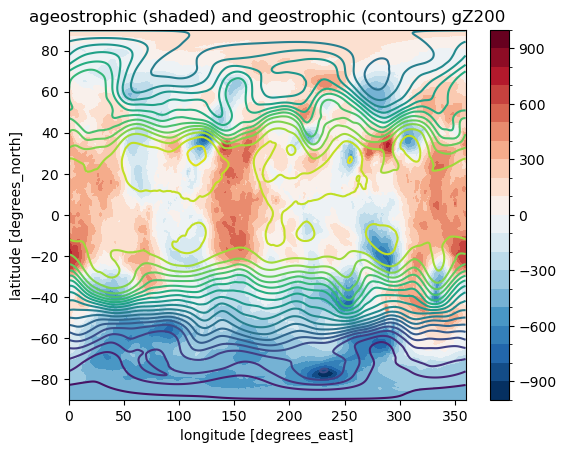

In [214]:
Za[1][9].plot.contourf(levels=25)
Zg[1][9].plot.contour(levels=25)

plt.title('ageostrophic (shaded) and geostrophic (contours) gZ200')

# For Hor. V Advection component, 
### instead of strf(fu,fv) WE want strf(-adv(v),adv(u)) 
just taking terms in analogous positions of u & v equations. I should recast this as "potentials" not "streamfunctions" for clarity, but am writing this in bashing-out mode at the moment

In [ ]:
# gradient method is a property of any windspharm object, like fV 
# zonal and meridional gradients of u and v 
du_zon, du_mer = fV.gradient(u)
dv_zon, dv_mer = fV.gradient(v)

#modeling on fV = windspharm.xarray.VectorWind(fu,fv) 
# Vector of horizontal advective accelerations
hadvA = windspharm.xarray.VectorWind(
    (u*dv_zon + v*dv_mer),-(u*du_zon + v*du_mer) )
Zhadv = hadvA.streamfunction()

Text(0.5, 1.0, '-V.gradV component (shaded) and Zageo (contours)')

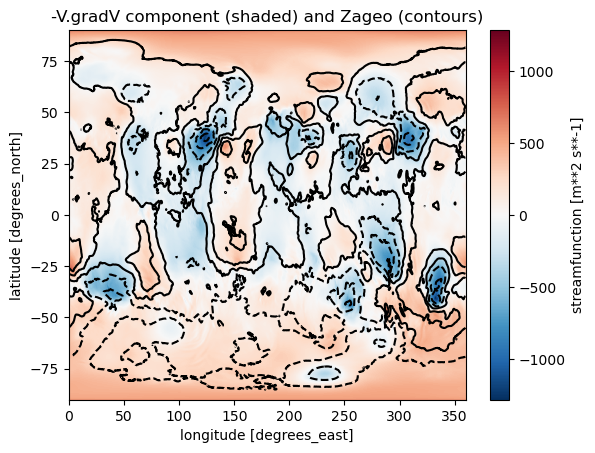

In [215]:
Zhadv[1][9].plot()
Za[1][9].plot.contour(levels=10,colors='k')
plt.title('-V.gradV component (shaded) and Zageo (contours)')

# Construct time-change component 
### instead of strf(fu,fv) use strf(dvdt,-dudt)

In [221]:
# gradient method is a property of any windspharm object, like fV 
# zonal and meridional gradients of u and v 
du_t = (u[2]-u[0]) /2./3600.  # acceleration units same as advection 
dv_t = (v[2]-v[0]) /2./3600.  # acceleration units same as advection 

#modeling on fV = windspharm.xarray.VectorWind(fu,fv) 
# Vector of accelerations, but taken over to RHS so sign flipped
accelA = windspharm.xarray.VectorWind(dv_t,-du_t)
Zacc = accelA.streamfunction()

Text(0.5, 1.0, 'Zaccel component (shaded) and Zageo (contours)')

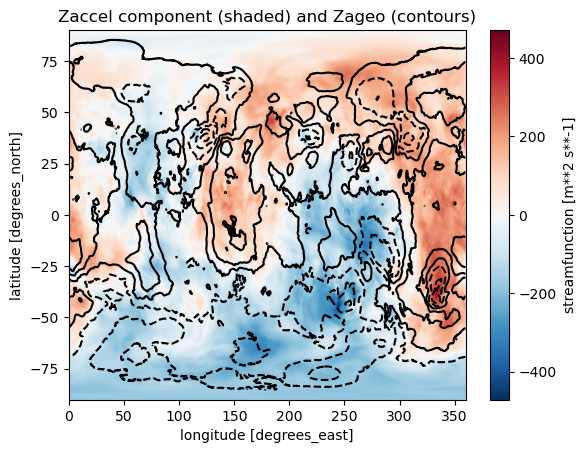

In [222]:
Zacc[9].plot()
Za[1][9].plot.contour(levels=10,colors='k')
plt.title('Zaccel component (shaded) and Zageo (contours)')

Text(0.5, 1.0, 'Zimb component (shaded) and Zageo (contours)')

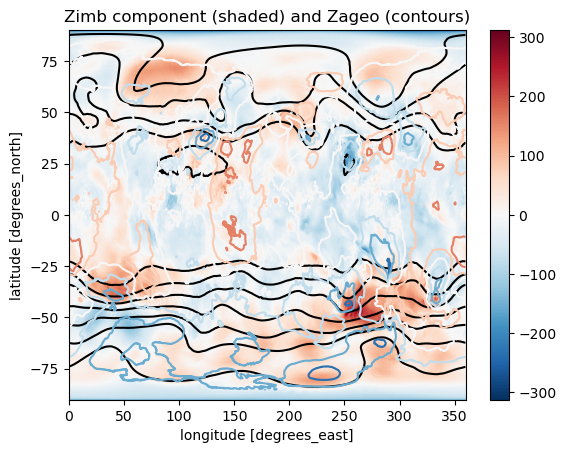

In [254]:
# Imbalance is friction, or vertical transport more generally

Zimb = Z[1] - Zg[1] - Zhadv[1] - Zacc 

# One prooblem: is the Coriolis parameter too weak by about 5% ? 
# TEST: subtract 5% of Zg pattern. Yes indeed! At 200 mb.

Zimb = Z[1] - Zg[1] - Zhadv[1] - Zacc -0.05*(Zg-globalZ)[1]

Zimb[9].plot()
Z[1][9].plot.contour(levels=10,colors='k')
Za[1][9].plot.contour(levels=10)
plt.title('Zimb component (shaded) and Zageo (contours)')

# Downward vertical integral of $\nabla^2 \Phi$ is omega tendency 
Obviously going to be terribly noisy... truncate to T21 or something

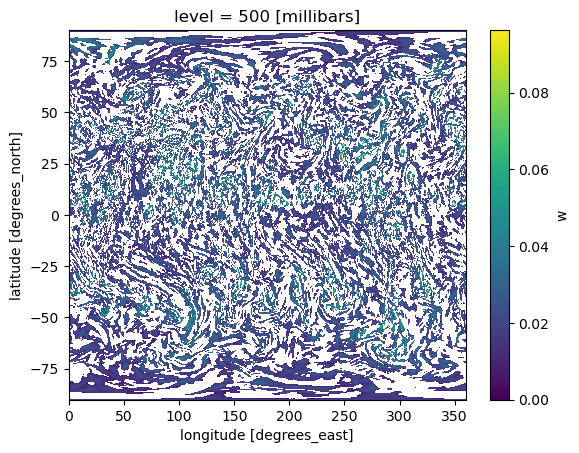

In [263]:
w = e53d['w']
wdot = (w[2]-w[0]) /2./3600.

# Plot cube root 
(wdot[16]**(1/3)).plot()

In [281]:
LapZg = fV.vorticity(truncation=21) # VORTICITY OF THE CORIOLIS FORCE ignore units, s-2 not s-1

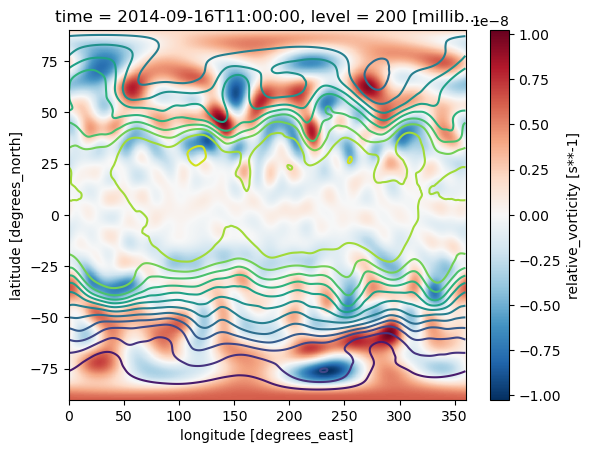

In [282]:
LapZg[1][9].plot()
Zg[1][9].plot.contour(levels=20)

In [ ]:
# Integrate LapZg downward